# Airbus Capstone Group 1


## Libraries Setup

In [ ]:
import pandas as pd
import numpy as np
from pycaret.classification import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

## File Upload

In [2]:
# Load the dataset
df = pd.read_csv("combined_simulated.csv")



# Define target variable
target = "LEAK_FLOW_FLAG"  # Target variable

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376554 entries, 0 to 376553
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   UTC_TIME                   376554 non-null  object 
 1   FUEL_USED_2                376554 non-null  float64
 2   FUEL_USED_3                376554 non-null  float64
 3   FUEL_USED_4                376554 non-null  float64
 4   FW_GEO_ALTITUDE            376554 non-null  float64
 5   VALUE_FOB                  376554 non-null  float64
 6   VALUE_FUEL_QTY_CT          376554 non-null  float64
 7   VALUE_FUEL_QTY_FT1         376554 non-null  float64
 8   VALUE_FUEL_QTY_FT2         376554 non-null  float64
 9   VALUE_FUEL_QTY_FT3         376554 non-null  float64
 10  VALUE_FUEL_QTY_FT4         376554 non-null  float64
 11  VALUE_FUEL_QTY_LXT         376554 non-null  float64
 12  VALUE_FUEL_QTY_RXT         376554 non-null  float64
 13  FLIGHT_PHASE_COUNT         37

We figured that sorting flight and time is critical for the model to detect tendencies

In [4]:
# Convert UTC_TIME to datetime format if it's not already
df['UTC_TIME'] = pd.to_datetime(df['UTC_TIME'])

# Sort by FLIGHT_ID and UTC_TIME
df_sorted = df.sort_values(by=['FLIGHT_ID', 'UTC_TIME'])

# Reset index
df_sorted = df_sorted.reset_index(drop=True)

In [5]:
df.head()

,UTC_TIME,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,FW_GEO_ALTITUDE,VALUE_FOB,VALUE_FUEL_QTY_CT,VALUE_FUEL_QTY_FT1,VALUE_FUEL_QTY_FT2,VALUE_FUEL_QTY_FT3,...,EXPECTED_FOB_CHANGE,FUEL_LEAK_RATE,TOTAL_FUEL_LW,TOTAL_FUEL_RW,LW_RW_DIFF,FUEL_IN_TANKS,CALC_VALUE_FOB_DIFF,START_FOB_VS_FOB_FUELUSED,ALTITUDE_DIFF,LEAK_FLOW_FLAG
0,2015-07-21 03:51:31,2454.501465,2444.412842,2481.687988,336.0,30967.0,0.0,1918.0,2620.0,2604.0,...,0.000000,0.000000,15477.0,15491.0,14.0,30968.0,1.0,-9827.431152,0.0,0
1,2016-08-16 12:29:02,531.809998,528.252380,523.025574,29998.0,19135.0,0.0,1963.0,2624.0,2443.0,...,7711.822815,19543.822815,9523.0,9612.0,89.0,19135.0,0.0,-2114.608337,29662.0,0
2,2016-08-16 12:29:03,532.141541,528.685181,523.363403,30010.0,19134.0,0.0,1966.0,2624.0,2442.0,...,-1.485291,-0.485291,9524.0,9612.0,88.0,19136.0,2.0,-2117.093628,12.0,0
3,2016-08-16 12:29:04,532.568909,529.068176,523.795654,30003.0,19136.0,0.0,1969.0,2624.0,2442.0,...,-1.674683,-3.674683,9526.0,9614.0,88.0,19140.0,4.0,-2122.768311,-7.0,0
4,2016-08-16 12:29:05,532.947754,529.499207,524.179749,29989.0,19133.0,0.0,1972.0,2624.0,2440.0,...,-1.527893,1.472107,9526.0,9611.0,85.0,19137.0,4.0,-2121.296204,-14.0,0


In [6]:
df_sorted['UTC_TIME'].describe()

count                  376554
unique                 373086
top       2017-04-04 13:18:00
freq                        2
first     2015-07-21 03:51:31
last      2018-04-22 11:45:45
Name: UTC_TIME, dtype: object

In [7]:
df_sorted['Flight'].value_counts()

357.0    10340
417.0     9912
395.0     9472
448.0     8843
359.0     8721
         ...  
81.0        54
257.0       52
306.0       51
85.0        12
988.0        1
Name: Flight, Length: 479, dtype: int64

Above, we noticed that there are some Flights that have few rows, but opted for not dropping them because they would not change much of the results and since there could be other instances of the same flight, then maybe best not disrupt the sequence of the dataset

In [8]:
df['FLIGHT_ID'].unique()

array(['988.0_0', '5.0_0', '9.0_0', '11.0_0', '12.0_0', '16.0_0',
       '17.0_0', '18.0_0', '21.0_0', '22.0_0', '23.0_0', '28.0_0',
       '44.0_0', '45.0_0', '46.0_0', '48.0_0', '53.0_0', '55.0_0',
       '2086.0_0', '2087.0_0', '58.0_0', '59.0_0', '2088.0_0', '2090.0_0',
       '2091.0_0', '2093.0_0', '2094.0_0', '67.0_0', '68.0_0', '69.0_0',
       '70.0_0', '71.0_0', '74.0_0', '1772.0_0', '77.0_0', '80.0_0',
       '1773.0_0', '83.0_0', '84.0_0', '86.0_0', '1777.0_0', '1787.0_0',
       '1789.0_0', '88.0_0', '1791.0_0', '1792.0_0', '1793.0_0', '95.0_0',
       '1798.0_0', '97.0_0', '1801.0_0', '98.0_0', '99.0_0', '1808.0_0',
       '1809.0_0', '103.0_0', '103.0_1', '103.0_2', '104.0_0', '105.0_0',
       '107.0_0', '1817.0_0', '108.0_0', '1818.0_0', '1821.0_0',
       '111.0_0', '112.0_0', '1822.0_0', '113.0_0', '114.0_0', '115.0_0',
       '1826.0_0', '116.0_0', '1827.0_0', '1828.0_0', '118.0_0',
       '119.0_0', '121.0_0', '122.0_0', '124.0_0', '125.0_0', '127.0_0',
       '129

We kept the numeric columns for the Pycaret setup

In [9]:
# Keep only numeric features
df = df_sorted.select_dtypes(include=[np.number])

Compared to other instances, we opted for removing certain columns that could not add much information and add unnecessary noice to the model

In [11]:
df = df.drop(columns=['FLIGHT_PHASE_COUNT','Flight','FLIGHT_INSTANCE'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376554 entries, 0 to 376553
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   FUEL_USED_2                376554 non-null  float64
 1   FUEL_USED_3                376554 non-null  float64
 2   FUEL_USED_4                376554 non-null  float64
 3   FW_GEO_ALTITUDE            376554 non-null  float64
 4   VALUE_FOB                  376554 non-null  float64
 5   VALUE_FUEL_QTY_CT          376554 non-null  float64
 6   VALUE_FUEL_QTY_FT1         376554 non-null  float64
 7   VALUE_FUEL_QTY_FT2         376554 non-null  float64
 8   VALUE_FUEL_QTY_FT3         376554 non-null  float64
 9   VALUE_FUEL_QTY_FT4         376554 non-null  float64
 10  VALUE_FUEL_QTY_LXT         376554 non-null  float64
 11  VALUE_FUEL_QTY_RXT         376554 non-null  float64
 12  FUEL_USED_1                376554 non-null  float64
 13  START_FOB                  37

## Pycaret Setup

In [13]:
# Initialize PyCaret and compare models
#clf_setup = setup(data=df, target=target, session_id=42, train_size=0.75)

# Pycaret Setup

clf_setup = setup(
    
    #Basic
    data = df, #Index was set at date for Dataviz purposes, but Pycaret needs default index format
    target = target,
    train_size = 0.75, # Train size of 75%


    
    #Feature Normalization
    normalize=True,
    normalize_method='zscore',

    #Transformation
    transformation = True,
    transformation_method='yeo-johnson', #Ensure proper handling of values and normalize the distribution

    # Dimensionality Reduction
    pca = False, #Not desired

    #Multicollinearity
    remove_multicollinearity=True,
    multicollinearity_threshold=0.80,#Features showing correlation of 80% or above are dropped

    data_split_shuffle=False,  # ✅ Prevents PyCaret from shuffling time order
    fold_shuffle=False,  # ✅ Ensures validation comes AFTER training
    data_split_stratify=False,  # ✅ Disables stratification (not allowed with time-series)
    fold_strategy = 'timeseries',


    #Paralellization Options
    n_jobs = -1,
    use_gpu= False,    
    
    html = True,
    session_id = 42
)

,Description,Value
0,Session id,42
1,Target,LEAK_FLOW_FLAG
2,Target type,Binary
3,Original data shape,"(376554, 28)"
4,Transformed data shape,"(376554, 17)"
5,Transformed train set shape,"(282415, 17)"
6,Transformed test set shape,"(94139, 17)"
7,Numeric features,27
8,Preprocess,True
9,Imputation type,simple


In [14]:
# Compare models and select the best one based on F1 score
best_model = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9055,0.9468,0.7876,0.5075,0.6144,0.5626,0.5823,17.3300
ada,Ada Boost Classifier,0.9048,0.9427,0.6157,0.5071,0.5528,0.4995,0.5045,4.3510
lightgbm,Light Gradient Boosting Machine,0.9044,0.9467,0.5668,0.5051,0.5301,0.4767,0.4800,1.2200
catboost,CatBoost Classifier,0.9051,0.9470,0.5366,0.5087,0.5198,0.4668,0.4683,16.3270
dt,Decision Tree Classifier,0.9047,0.7208,0.4954,0.5077,0.4999,0.4466,0.4474,1.3550
xgboost,Extreme Gradient Boosting,0.9051,0.9470,0.4855,0.5097,0.4945,0.4418,0.4435,1.2950
rf,Random Forest Classifier,0.9040,0.9471,0.3065,0.5119,0.3684,0.3217,0.3394,6.4070
lr,Logistic Regression,0.9045,0.9428,0.2730,0.5054,0.3271,0.2841,0.3090,3.5330
knn,K Neighbors Classifier,0.8780,0.7581,0.2919,0.3373,0.3038,0.2390,0.2441,37.8500
qda,Quadratic Discriminant Analysis,0.8936,0.9004,0.1780,0.3411,0.2147,0.1696,0.1854,0.8930


In [ ]:
model_mapping = {
    'gbc': 'GradientBoostingClassifier',
    'ada': 'AdaBoostClassifier',
    'lightgbm': 'LGBMClassifier',
    'dt': 'DecisionTreeClassifier',
    'catboost': 'CatBoostClassifier',
    'xgboost': 'XGBClassifier',
    'rf': 'RandomForestClassifier',
    'qda': 'QuadraticDiscriminantAnalysis',
    'svm': 'SVC',  # SVM for classification 
    'lr': 'LogisticRegression',
    'knn': 'KNeighborsClassifier',
    'nb': 'GaussianNB',  # Naive Bayes (assumed Gaussian)
    'lda': 'LinearDiscriminantAnalysis',
    'ridge': 'RidgeClassifier',  # Ridge for classification
    'et': 'ExtraTreesClassifier',
    'dummy': 'DummyClassifier',
}


# Find the short name for the best model
for short_name, model_name in model_mapping.items():
    if type(best_model).__name__ == model_name:
        best_model_short_name = short_name
        break

best_model_short_name.__str__

best_model_short_name

'gbc'

In [16]:
best_model = create_model(best_model_short_name, fold = 5, round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.89,0.94,0.74,0.50,0.60,0.54,0.55
1,0.94,0.97,0.78,0.52,0.62,0.59,0.60
2,0.94,0.97,0.81,0.51,0.62,0.60,0.61
3,0.88,0.93,0.90,0.50,0.64,0.57,0.61
4,0.88,0.93,0.93,0.51,0.66,0.59,0.63
Mean,0.91,0.95,0.83,0.51,0.63,0.58,0.60
Std,0.03,0.02,0.07,0.01,0.02,0.02,0.03


In [17]:
tuned_model = tune_model(best_model,optimize="f1")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8864,0.9354,0.6302,0.5107,0.5642,0.4997,0.5033
1,0.9099,0.9511,0.8942,0.5092,0.6489,0.6016,0.6330
2,0.9099,0.9508,0.5674,0.5030,0.5333,0.4836,0.4847
3,0.9171,0.9545,0.6984,0.5197,0.5959,0.5508,0.5583
4,0.9610,0.9795,0.7772,0.5292,0.6297,0.6099,0.6224
5,0.9408,0.9688,0.6928,0.5057,0.5846,0.5536,0.5616
6,0.9126,0.9524,0.8902,0.4985,0.6391,0.5939,0.6262
7,0.8638,0.9218,0.9117,0.5002,0.6459,0.5703,0.6098
8,0.8414,0.9060,0.9193,0.4988,0.6467,0.5558,0.5990


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [18]:
# Finalize the model to make it ready for predictions
final_model = finalize_model(tuned_model)

In [19]:
predictions = predict_model(final_model,df.reset_index())

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9166,0.9568,0.9084,0.5175,0.6594,0.6159,0.6476


In [20]:
final_model = finalize_model(tuned_model)

# Combine X_train and y_train to create a full training dataset
X_train = get_config('X_train')
y_train = get_config('y_train')
train_data = pd.concat([X_train, y_train], axis=1)

# Combine X_test and y_test to create a full test dataset
X_test = get_config('X_test')
y_test = get_config('y_test')
test_data = pd.concat([X_test, y_test], axis=1)

# Train metrics
train_predictions = predict_model(final_model, data=train_data)
train_metrics = pull()
print("Training Metrics:")
print(train_metrics)

# Test metrics
test_predictions = predict_model(final_model, data=test_data)
test_metrics = pull()
print("\nTest Metrics:")
print(test_metrics)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9105,0.9534,0.9100,0.5167,0.6591,0.6120,0.6446


Training Metrics:
                          Model  Accuracy     AUC  Recall   Prec.      F1  \
0  Gradient Boosting Classifier    0.9105  0.9534    0.91  0.5167  0.6591   

   Kappa     MCC  
0  0.612  0.6446  


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9348,0.9670,0.9019,0.5211,0.6605,0.6273,0.6563



Test Metrics:
                          Model  Accuracy    AUC  Recall   Prec.      F1  \
0  Gradient Boosting Classifier    0.9348  0.967  0.9019  0.5211  0.6605   

    Kappa     MCC  
0  0.6273  0.6563  


Ok, so the model had very high accuracy, AUC, and Recall, but we were mostly centered on improving F1 because we have to be aware of the False Positive from this model. An F1 score of 66% is not bad, but it serves as a starting point to detect leaks, specially with such a strong Recall.

In [ ]:
# We save the model
pipeline = save_model(final_model, 'model_f2')

Transformation Pipeline and Model Successfully Saved


In [21]:
predictions.tail()

,index,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,FW_GEO_ALTITUDE,VALUE_FOB,VALUE_FUEL_QTY_CT,VALUE_FUEL_QTY_FT1,VALUE_FUEL_QTY_FT2,VALUE_FUEL_QTY_FT3,...,TOTAL_FUEL_LW,TOTAL_FUEL_RW,LW_RW_DIFF,FUEL_IN_TANKS,CALC_VALUE_FOB_DIFF,START_FOB_VS_FOB_FUELUSED,ALTITUDE_DIFF,LEAK_FLOW_FLAG,prediction_label,prediction_score
376549,376549,95.822327,90.598366,87.559669,469.0,23992.0,0.0,1410.0,2149.0,2020.0,...,12171.0,11823.0,348.0,23994.0,2.0,-274.405762,1.0,0,0,0.9997
376550,376550,96.110596,90.921471,87.837906,463.0,23985.0,0.0,1407.0,2150.0,2017.0,...,12168.0,11818.0,350.0,23986.0,1.0,-267.584656,-35526.0,0,0,0.9998
376551,376551,96.421616,91.192993,88.142586,463.0,23977.0,0.0,1407.0,2150.0,2016.0,...,12167.0,11811.0,356.0,23978.0,1.0,-260.778473,-35531.0,1,1,0.6420
376552,376552,96.677055,91.447716,88.396881,467.0,23975.0,0.0,1407.0,2146.0,2017.0,...,12159.0,11816.0,343.0,23975.0,0.0,-258.796814,-35524.0,0,0,0.9998
376553,376553,96.708519,91.478584,88.396881,460.0,23968.0,0.0,1407.0,2146.0,2015.0,...,12160.0,11810.0,350.0,23970.0,2.0,-253.859146,-35535.0,0,0,0.9998


In [22]:
predictions.to_csv('airbus_predictions.csv')

In [23]:
predictions['prediction_label'].value_counts()

0    317798
1     58756
Name: prediction_label, dtype: int64

In [24]:
predictions['LEAK_FLOW_FLAG'].value_counts()

0    343079
1     33475
Name: LEAK_FLOW_FLAG, dtype: int64

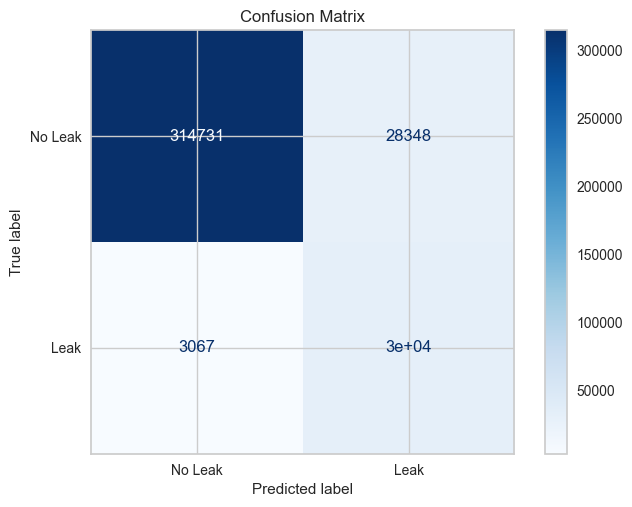

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Generate confusion matrix
cm = confusion_matrix(predictions['LEAK_FLOW_FLAG'], predictions['prediction_label'])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Leak', 'Leak'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


As expected from before, TNegatives populate the confusion matrix, while False Negatives are scarce. As expected from our F1 scores, we have many False Positives, but we believe having such a small number of False Negatives bring a lot of value from the model.

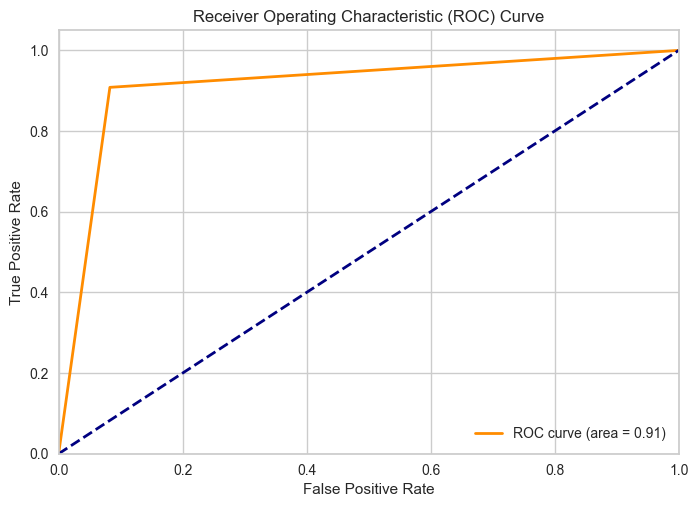

In [28]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, _ = roc_curve(predictions['LEAK_FLOW_FLAG'], predictions['prediction_label'])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


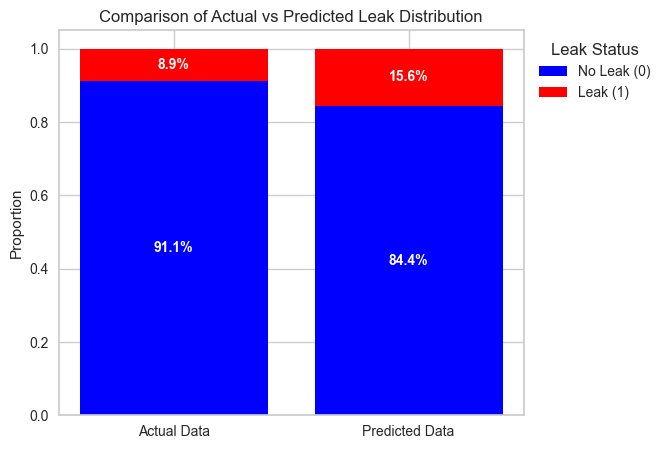

In [40]:
import matplotlib.pyplot as plt

# Get actual and predicted counts
actual_counts = predictions['LEAK_FLOW_FLAG'].value_counts(normalize=True)  # Normalize to get proportions
predicted_counts = predictions['prediction_label'].value_counts(normalize=True)  # Normalize to get proportions

# Define categories
labels = ['No Leak (0)', 'Leak (1)']
actual_values = [actual_counts[0], actual_counts[1]]  # Proportion of actual labels
predicted_values = [predicted_counts[0], predicted_counts[1]]  # Proportion of predicted labels

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(6, 5))

# Plot actual distribution
bar1 = ax.bar('Actual Data', actual_values[0], label='No Leak', color='blue')
bar2 = ax.bar('Actual Data', actual_values[1], bottom=actual_values[0], label='Leak', color='red')

# Plot predicted distribution
bar3 = ax.bar('Predicted Data', predicted_values[0], color='blue')
bar4 = ax.bar('Predicted Data', predicted_values[1], bottom=predicted_values[0], color='red')

# Add percentage text on bars for No Leak (blue part)
for bar, value in zip([bar1, bar3], [actual_values[0], predicted_values[0]]):
    height = bar[0].get_height()
    ax.text(bar[0].get_x() + bar[0].get_width() / 2, height / 2,
            f"{value*100:.1f}%", ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# Add percentage text on bars for Leak (red part)
for bar, value, bottom_value in zip([bar2, bar4], [actual_values[1], predicted_values[1]], [actual_values[0], predicted_values[0]]):
    height = bar[0].get_height()
    ax.text(bar[0].get_x() + bar[0].get_width() / 2, bottom_value + height / 2,
            f"{value*100:.1f}%", ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# Labels and Title
plt.ylabel("Proportion")
plt.title("Comparison of Actual vs Predicted Leak Distribution")

# Adjust legend position
plt.legend(title="Leak Status", labels=['No Leak (0)', 'Leak (1)'], loc='upper right', bbox_to_anchor=(1.3, 1))

# Show Plot
plt.show()


As expected, we are predicting much more Leaks than in the original data, specially from those False Positive outputs.